In [1]:
#Importação das bibliotecas necessárias - Essa célula deve ser executada antes de todas as outras
import cv2
import matplotlib.pyplot as plt
import numpy as np

#### Todas as demais células podem ser executadas independentemente. Para mudar a imagem de entrada, basta trocar o nome da imagem na variável 'img_name' por um outro nome válido na pasta in.


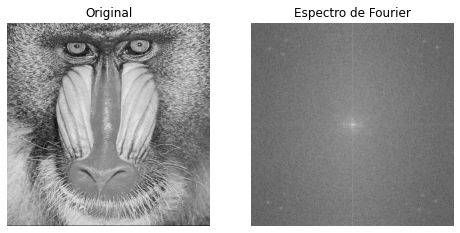

In [2]:
img_name = 'baboon.png'
img = cv2.imread('in/' + img_name, 0)

if img is None:
    sys.exit("Could not read the image.")

# Aplica transformada rápida d Fourier
ft = np.fft.fft2(img)
ft = np.fft.fftshift(ft)
# Para visualizar o espectro de Fourier tomamos o logaritmo da magnitude (valor absoluto).
# Somamos 1 ao valor para garantir que o logaritmo esteja definido.
espectro = np.log(np.abs(ft) + 1)
max_pixel = np.max(espectro)
if max_pixel > 0:
    # Fazemos com que os valores do espectro estejam no intervalo [0, 255].
    espectro = (255/max_pixel)*espectro

# Desfaz o shift e aplica a transformada inversa
fshift = np.fft.ifftshift(ft)
img = np.fft.ifft2(fshift)
img = np.real(img)

f, axarr = plt.subplots(1,2, figsize = (8,8))
axarr[0].imshow(img, cmap = 'gray')
axarr[0].set_title("Original")
axarr[0].axis('off')

axarr[1].imshow(espectro, cmap = 'gray')
axarr[1].set_title("Espectro de Fourier")
axarr[1].axis('off')
plt.show()

if not cv2.imwrite('out/espectro.png', espectro):
    print("Falha ao salvar a imagem")

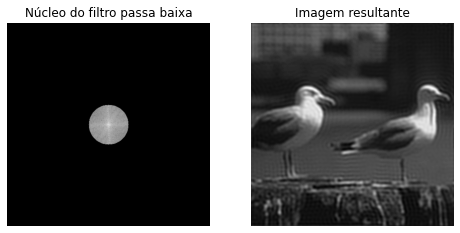

In [3]:
img_name = 'seagull.png'
img = cv2.imread('in/' + img_name, 0)

if img is None:
    sys.exit("Could not read the image.")

ft = np.fft.fft2(img)
ft = np.fft.fftshift(ft)

espectro = np.log(np.abs(ft) + 1)
max_pixel = np.max(espectro)
if max_pixel > 0:
    espectro = (255/max_pixel)*espectro

# Cria o círculo para filtrar a imagem
height = len(img)
width = len(img[0])
circle = np.zeros((height, width), np.uint8)
circle = cv2.circle(circle, (int(height/2), int(width/2)), 50, 1, -1)

low_pass = np.multiply(ft, circle)
nucleo = np.multiply(espectro, circle)

fshift = np.fft.ifftshift(low_pass)
low_pass = np.fft.ifft2(fshift)
low_pass = np.real(low_pass)

f, axarr = plt.subplots(1,2, figsize = (8,8))
axarr[0].imshow(nucleo, cmap = 'gray')
axarr[0].set_title("Núcleo do filtro passa baixa")
axarr[0].axis('off')

axarr[1].imshow(low_pass, cmap = 'gray')
axarr[1].set_title("Imagem resultante")
axarr[1].axis('off')
plt.show()

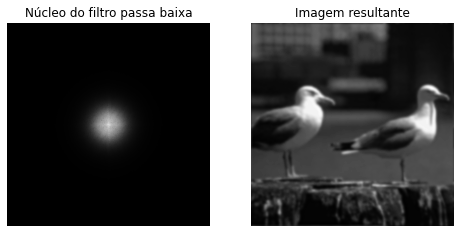

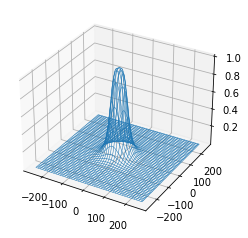

In [4]:
img_name = 'seagull.png'
img = cv2.imread('in/' + img_name, 0)

if img is None:
    sys.exit("Could not read the image.")

ft = np.fft.fft2(img)
ft = np.fft.fftshift(ft)

# Parâmetros do filtro de Butterworth:
#   n: ordem
#   D0: frequência de corte
n = 2
D0 = 40
x, y = np.shape(ft)
x_axis = np.arange(-np.floor(x/2), np.floor(x/2))
y_axis = np.arange(-np.floor(y/2), np.floor(y/2))
# Gera o plano para o cálculo de D
A, B = np.meshgrid(x_axis, y_axis)
D = np.sqrt(np.power(A, 2) + np.power(B, 2))
H = 1/(1 + (D/D0)**(2*n))
# Operação de convolução
butterworth = H * ft

# Desfaz o shift e aplica a transformada inversa
butterworth = np.fft.ifftshift(butterworth)
butterworth = np.fft.ifft2(butterworth)
butterworth = np.real(butterworth)

espectro = np.log(np.abs(ft) + 1)
max_pixel = np.max(espectro)
if max_pixel > 0:
    espectro = (255/max_pixel)*espectro

f, axarr = plt.subplots(1,2, figsize = (8,8))
axarr[0].imshow(H * espectro, cmap = 'gray')
axarr[0].set_title("Núcleo do filtro passa baixa")
axarr[0].axis('off')

axarr[1].imshow(butterworth, cmap = 'gray')
axarr[1].set_title("Imagem resultante")
axarr[1].axis('off')
plt.show()

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
plot = ax.plot_wireframe(A, B, H, linewidth=0.5)
plt.show()

if not cv2.imwrite('out/low_butter.png', butterworth):
    print("Falha ao salvar a imagem")

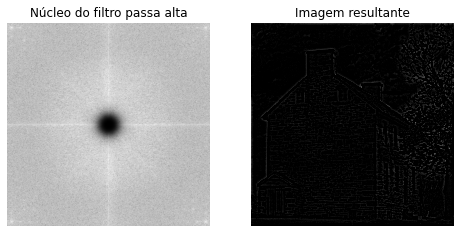

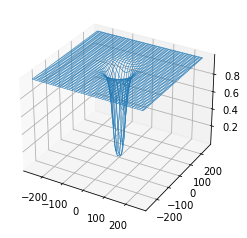

In [26]:
img_name = 'house.png'
img = cv2.imread('in/' + img_name, 0)

if img is None:
    sys.exit("Could not read the image.")

ft = np.fft.fft2(img)
ft = np.fft.fftshift(ft)

# Parâmetros do filtro de Butterworth:
#   n: ordem
#   D0: frequência de corte
n = 2
D0 = 30
x, y = np.shape(ft)
x_axis = np.arange(-np.floor(x/2), np.floor(x/2))
y_axis = np.arange(-np.floor(y/2), np.floor(y/2))
A, B = np.meshgrid(x_axis, y_axis)
# Somando 1 para evitar divisão por 0
D = np.sqrt(np.power(A, 2) + np.power(B, 2) + 1)
H = 1/(1 + (D0/D)**(2*n))
butterworth = H * ft

# Desfaz o shift e aplica a transformada inversa
butterworth = np.fft.ifftshift(butterworth)
butterworth = np.fft.ifft2(butterworth)
butterworth = np.real(butterworth)

espectro = np.log(np.abs(ft) + 1)
max_pixel = np.max(espectro)
if max_pixel > 0:
    espectro = (255/max_pixel)*espectro

f, axarr = plt.subplots(1,2, figsize = (8,8))
axarr[0].imshow(H * espectro, cmap = 'gray')
axarr[0].set_title("Núcleo do filtro passa alta")
axarr[0].axis('off')

axarr[1].imshow(butterworth, cmap = 'gray', vmin=0, vmax=255)
axarr[1].set_title("Imagem resultante")
axarr[1].axis('off')
plt.show()

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
plot = ax.plot_wireframe(A, B, H, linewidth=0.5)
plt.show()

if not cv2.imwrite('out/high_butter.png', butterworth):
    print("Falha ao salvar a imagem")

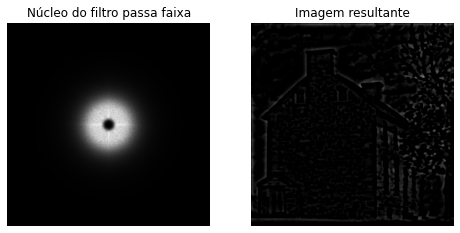

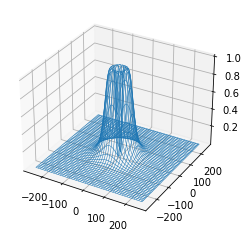

In [27]:
img_name = 'house.png'
img = cv2.imread('in/' + img_name, 0)

if img is None:
    sys.exit("Could not read the image.")

ft = np.fft.fft2(img)
ft = np.fft.fftshift(ft)

# Parâmetros do filtro de Butterworth:
#   n: ordem
#   D0: frequência de corte
#   W: largura da banda
n = 2
D0 = 30
W = 50
x, y = np.shape(ft)
x_axis = np.arange(-np.floor(x/2), np.floor(x/2))
y_axis = np.arange(-np.floor(y/2), np.floor(y/2))
A, B = np.meshgrid(x_axis, y_axis)
# Somando 1 para evitar divisão por 0
D = np.sqrt(np.power(A, 2) + np.power(B, 2) + 1)
H = 1 - 1/(1 + ((W * D)/(D**2 - D0**2))**(2*n))
butterworth = H * ft

# Desfaz o shift e aplica a transformada inversa
butterworth = np.fft.ifftshift(butterworth)
butterworth = np.fft.ifft2(butterworth)
butterworth = np.real(butterworth)

espectro = np.log(np.abs(ft) + 1)
max_pixel = np.max(espectro)
if max_pixel > 0:
    espectro = (255/max_pixel)*espectro

f, axarr = plt.subplots(1,2, figsize = (8,8))
axarr[0].imshow(H * espectro, cmap = 'gray')
axarr[0].set_title("Núcleo do filtro passa faixa")
axarr[0].axis('off')

axarr[1].imshow(butterworth, cmap = 'gray', vmin=0, vmax=255)
axarr[1].set_title("Imagem resultante")
axarr[1].axis('off')
plt.show()

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
plot = ax.plot_wireframe(A, B, H, linewidth=0.5)
plt.show()

if not cv2.imwrite('out/band_butter.png', butterworth):
    print("Falha ao salvar a imagem")

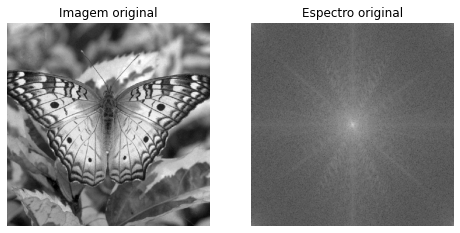

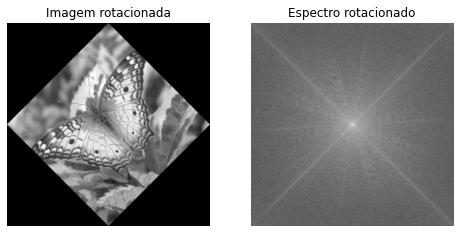

In [42]:
import skimage as sk
from skimage import transform

img_name = 'butterfly.png'
img = cv2.imread('in/' + img_name, 0)

if img is None:
    sys.exit("Could not read the image.")

ft = np.fft.fft2(img)
ft = np.fft.fftshift(ft)

# Calcula o espectro da imagem original
espectro = np.log(np.abs(ft) + 1)
max_pixel = np.max(espectro)
if max_pixel > 0:
    espectro = (255/max_pixel)*espectro

# Rotaciona a imagem e reajusta seu tamanho para não ocorrer cortes
img_rot = transform.rotate(img, 45, resize=True)
# Reajusta a escala dos pixels
img_rot = 255/np.max(img_rot) * img_rot

ft_rot = np.fft.fft2(img_rot)
ft_rot = np.fft.fftshift(ft_rot)

# Calcula o espectro da imagem rotacionada
espectro_rot = np.log(np.abs(ft_rot) + 1)
max_pixel = np.max(espectro_rot)
if max_pixel > 0:
    espectro_rot = (255/max_pixel)*espectro_rot

f, axarr = plt.subplots(1,2, figsize = (8,8))
axarr[0].imshow(img, cmap = 'gray')
axarr[0].set_title("Imagem original")
axarr[0].axis('off')

axarr[1].imshow(espectro, cmap = 'gray')
axarr[1].set_title("Espectro original")
axarr[1].axis('off')
plt.show()

f, axarr = plt.subplots(1,2, figsize = (8,8))
axarr[0].imshow(img_rot, cmap = 'gray')
axarr[0].set_title("Imagem rotacionada")
axarr[0].axis('off')

axarr[1].imshow(espectro_rot, cmap = 'gray')
axarr[1].set_title("Espectro rotacionado")
axarr[1].axis('off')
plt.show()

if not cv2.imwrite('out/rotated.png', img_rot):
    print("Falha ao salvar a imagem")
if not cv2.imwrite('out/rotated_spec.png', espectro_rot):
    print("Falha ao salvar a imagem")

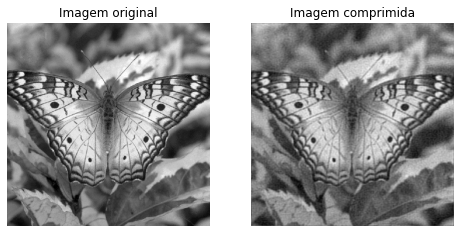

In [40]:
img_name = 'butterfly.png'
img = cv2.imread('in/' + img_name, 0)

if img is None:
    sys.exit("Could not read the image.")

ft = np.fft.fft2(img)
ft = np.fft.fftshift(ft)

# O código de compressão de imagem a seguir foi baseado em [1]
# Ordenamos os coeficientes da transformada de modo a escolher um threshold 
# que delimita uma certa porcentagem dos maiores valores 
coef = np.sort(np.abs(np.reshape(ft,-1)))
keep = 0.05
threshold = coef[int(np.floor((1-keep)*len(coef)))]
ind = np.abs(ft) > threshold
compressed = ft * ind

# Desfaz o shift e aplica a transformada inversa
compressed = np.fft.ifftshift(compressed)
compressed = np.fft.ifft2(compressed)
compressed = np.real(compressed)

f, axarr = plt.subplots(1,2, figsize = (8,8))
axarr[0].imshow(img, cmap = 'gray')
axarr[0].set_title("Imagem original")
axarr[0].axis('off')

axarr[1].imshow(compressed, cmap = 'gray')
axarr[1].set_title("Imagem comprimida")
axarr[1].axis('off')
plt.show()

if not cv2.imwrite('out/compressed.png', compressed):
    print("Falha ao salvar a imagem")

\[1\] BRUNTON,S.L;KUTZ, J.N. Sparcity and Compressed Sensing. _Data-Driven Science and Engineering: Machine Learning, Dynamical Systems and Control_. \[S.l.: s.n.\]. p.98.